# Kaggle: Red Wine Quality (Cortez et al. 2009)

이 노트북은 Kaggle의 Red Wine Quality 데이터셋(P. Cortez et al., 2009)을 활용하여 레드 와인의 품질을 예측하는 모델을 만드는 과정을 담고 있습니다.
데이터셋은 UCI Machine Learning Repository에서 직접 다운로드하여 사용합니다.

## 데이터셋 설명 (Dataset Description)

- **데이터셋**: Red Wine Quality Dataset
- **출처**: [Kaggle Link](https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009) / [UCI Link](https://archive.ics.uci.edu/ml/datasets/wine+quality)
- **데이터 개수**: 1,599개
- **특성(Features)**: 11개 (화학적 특성)
- **타겟(Target)**: quality (0에서 10 사이의 점수)

### 변수 설명 (Variables)
1. **fixed acidity** (고정 산도): 와인의 산도와 관련된 고정된 산의 양
2. **volatile acidity** (휘발성 산도): 와인에서 식초 맛을 내는 휘발성 산의 양 (너무 높으면 좋지 않음)
3. **citric acid** (구연산): 와인의 신선함을 더해주는 산
4. **residual sugar** (잔류 당분): 발효 후 남은 당분 (와인의 단맛 결정)
5. **chlorides** (염화물): 와인 내 소금의 양
6. **free sulfur dioxide** (유리 이산화황): 미생물 번식과 산화를 방지하는 SO2 형태
7. **total sulfur dioxide** (총 이산화황): 유리형과 결합형 SO2의 총합
8. **density** (밀도): 알코올 함량과 당분에 따라 달라지는 와인의 밀도
9. **pH**: 와인의 산성도 (0: 강산성 ~ 14: 강알칼리성, 보통 3-4 사이)
10. **sulphates** (황산염): 이산화황 농도에 영향을 주어 항균 및 항산화 작용을 함
11. **alcohol** (알코올 도수): 와인의 알코올 함량 (% vol)
12. **quality** (품질): 출력 변수 (0~10 사이의 점수, 3이 가장 낮고 8이 가장 높음)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request

# 전처리 라이브러리
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 머신러닝 모델
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
# 평가 지표
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import warnings
warnings.filterwarnings('ignore')

## 1. 데이터 로드 (Data Load)

Kaggle에서 데이터를 직접 다운로드합니다.

In [2]:
# kaggle에 로그인을 해서 데이터셋을 다운로드 받기 위해
# 로그인을 위한 키값을 설정
from dotenv import load_dotenv
# .env로 부터 파일을 읽으면 True가 출력
print(load_dotenv())

True


In [3]:
#!/bin/bashkaggle
!kaggle datasets download uciml/red-wine-quality-cortez-et-al-2009

Dataset URL: https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009
License(s): DbCL-1.0
red-wine-quality-cortez-et-al-2009.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
import os
# 압축 파일 경로 (정방향 슬래시 사용)
zip_file_path = 'C:/Users/park/iCloudDrive/2025/EST_AI_MODEL_DEVEL/ESTSoft/DataScience/scikit-learn/red-wine-quality-cortez-et-al-2009.zip'
# 압축을 풀 대상 디렉토리
extract_to_path = 'C:/Users/park/iCloudDrive/2025/EST_AI_MODEL_DEVEL/ESTSoft/DataScience/scikit-learn/data'

# zip 파일 열기 및 압축 해제
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)
    print(f"압축 해제 완료: {extract_to_path}")
# 해제된 파일 목록 확인
print("현재 폴더 파일 목록:", os.listdir(extract_to_path))


압축 해제 완료: C:/Users/park/iCloudDrive/2025/EST_AI_MODEL_DEVEL/ESTSoft/DataScience/scikit-learn/data
현재 폴더 파일 목록: ['teenage_mental.xls', 'titanic', 'winequality-red.csv']


In [5]:
import pandas as pd

filename = os.path.join(extract_to_path, 'winequality-red.csv')
# 세미콜론(;)으로 구분된 CSV 파일
df = pd.read_csv(filename)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## 2. 데이터 분석 (EDA)

In [6]:
print("### Data Info ###")
print(df.info())

### Data Info ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


In [7]:
print("\n### Basic Statistics ###")
display(df.describe().round(4))


### Basic Statistics ###


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.0000,1599.0000,1599.0000,1599.0000,1599.0000,1599.0000,1599.0000,1599.0000,1599.0000,1599.0000,1599.0000,1599.0000
mean,8.3196,0.5278,0.2710,2.5388,0.0875,15.8749,46.4678,0.9967,3.3111,0.6581,10.4230,5.6360
std,1.7411,0.1791,0.1948,1.4099,0.0471,10.4602,32.8953,0.0019,0.1544,0.1695,1.0657,0.8076
min,4.6000,0.1200,0.0000,0.9000,0.0120,1.0000,6.0000,0.9901,2.7400,0.3300,8.4000,3.0000
25%,7.1000,0.3900,0.0900,1.9000,0.0700,7.0000,22.0000,0.9956,3.2100,0.5500,9.5000,5.0000
50%,7.9000,0.5200,0.2600,2.2000,0.0790,14.0000,38.0000,0.9968,3.3100,0.6200,10.2000,6.0000
75%,9.2000,0.6400,0.4200,2.6000,0.0900,21.0000,62.0000,0.9978,3.4000,0.7300,11.1000,6.0000
max,15.9000,1.5800,1.0000,15.5000,0.6110,72.0000,289.0000,1.0037,4.0100,2.0000,14.9000,8.0000


In [8]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3])

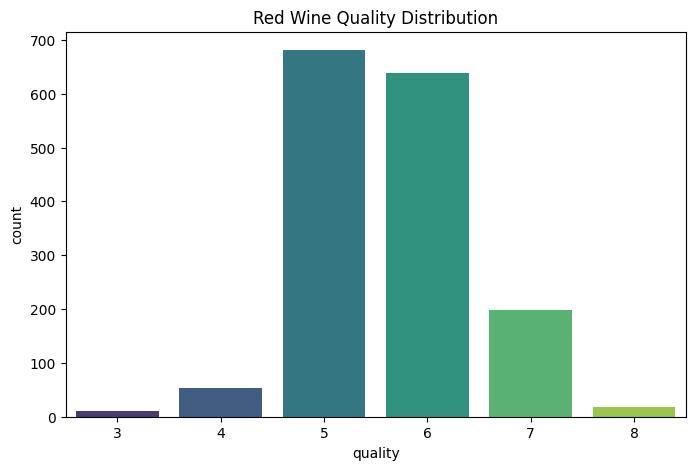

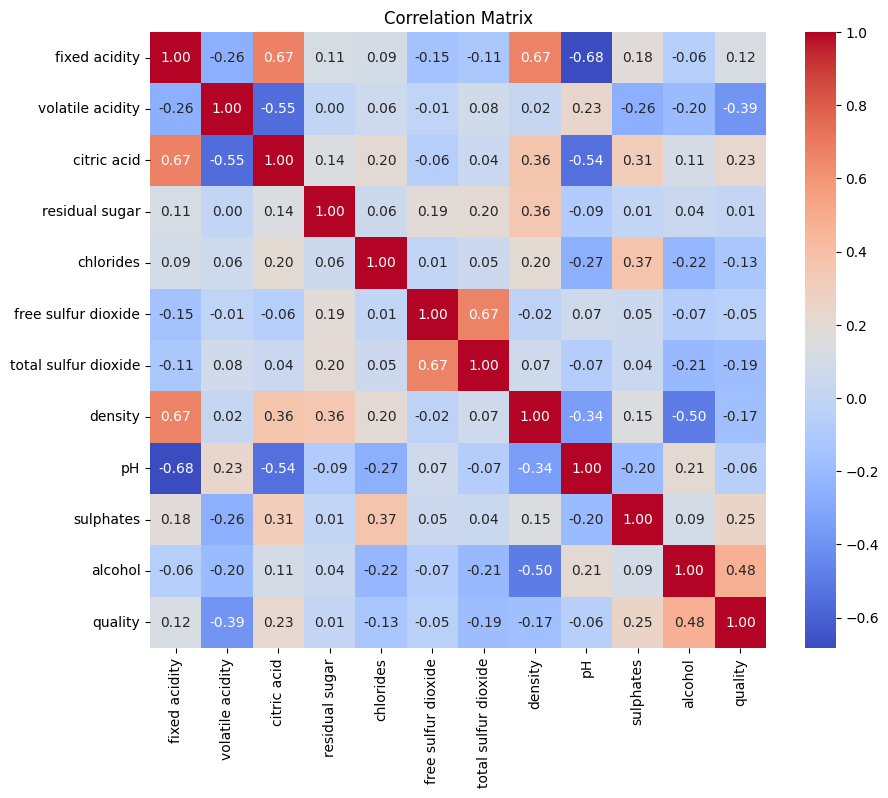

In [9]:
# 타겟 변수(Quality) 분포 확인
plt.figure(figsize=(8, 5))
sns.countplot(x='quality', data=df, palette='viridis')
plt.title("Red Wine Quality Distribution")
plt.show()

# 상관관계 히트맵
plt.figure(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("Correlation Matrix")
plt.show()

## 3. 데이터 전처리 및 특성 엔지니어링

- **특성 엔지니어링**: 산도 관련 특성들을 합쳐서 `total acidity`를 만들어 봅니다 (선택 사항).
- **이진 분류 변환 (선택)**: 원래 점수(0~10)를 그대로 쓸 수도 있지만, 보통 좋은 와인(예: 7 이상)과 나쁜 와인으로 나누거나 그대로 멀티 클래스로 분류합니다. 여기서는 **멀티 클래스 분류(각 점수별 예측)**를 수행하되, 데이터가 적은 클래스(3, 8 등)를 고려해야 합니다. 
  > 여기서는 **quality 그대로를 클래스로 사용하는 멀티클래스 분류**로 진행합니다.

- **스케일링**: 대부분의 모델(SVM, KNN, Logistic 등)은 특성 스케일에 민감하므로 `StandardScaler`를 적용합니다.

In [10]:
# 특성 엔지니어링 (예: 총 산도)
# df['total_acidity'] = df['fixed acidity'] + df['volatile acidity'] + df['citric acid']
# 이 예제에서는 원본 특성을 유지하며 진행합니다.

X = df.drop('quality', axis=1)
y = df['quality']

# 타겟 클래스 개수가 적은 경우 (예: quality 3, 8) Stratified Split 사용 권장
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train shape: {X_train_scaled.shape}, Test shape: {X_test_scaled.shape}")

Train shape: (1279, 11), Test shape: (320, 11)


In [11]:
# y_train에서 숫자별 데이터의 갯수 확인
print(y_train.value_counts())
print(y_test.value_counts())

quality
5    545
6    510
7    159
4     42
8     15
3      8
Name: count, dtype: int64
quality
5    136
6    128
7     40
4     11
8      3
3      2
Name: count, dtype: int64


In [12]:
#!pip install imbalanced-learn

In [13]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

In [14]:
print(pd.Series(y_train[:]).value_counts())
print(pd.Series(y_train_res[:]).value_counts())

quality
5    545
6    510
7    159
4     42
8     15
3      8
Name: count, dtype: int64
quality
6    545
5    545
7    545
3    545
4    545
8    545
Name: count, dtype: int64


## 4. 모델링 (8가지 모델)

In [15]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=2000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced_subsample'),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'ExtraTrees': ExtraTreesClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

results = {}
print("### Initial Model Performance (Accuracy) ###")
for name, model in models.items():
    #model.fit(X_train_scaled, y_train)
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: {acc:.4f}")

# 상위 4개 모델 선정
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
top_4_names = [item[0] for item in sorted_results[:4]]
print(f"\nTop 4 Models: {top_4_names}")

### Initial Model Performance (Accuracy) ###
LogisticRegression: 0.3656
DecisionTree: 0.5813
RandomForest: 0.6312
SVM: 0.5094
KNN: 0.5000
GradientBoosting: 0.5563
ExtraTrees: 0.6094
AdaBoost: 0.3937

Top 4 Models: ['RandomForest', 'ExtraTrees', 'DecisionTree', 'GradientBoosting']


## 5. 하이퍼 파라메터 튜닝 및 앙상블

상위 4개 모델에 대해 `GridSearchCV` 또는 간단한 튜닝을 수행한 후, `VotingClassifier`로 앙상블합니다.

In [16]:
# Top 4 모델 객체 가져오기
top_models = {}
for name in top_4_names:
    top_models[name] = models[name]

# 튜닝을 위한 파라미터 그리드 예시 (시간 관계상 일부만 간단히 설정)
param_grids = {
    'RandomForest': {'n_estimators': [50, 100, 200, 300], 'max_depth': [10, 20, 25, None], 'class_weight':['balanced','balanced_subsample',None]},
    'ExtraTrees': {'n_estimators': [50, 70, 100, 200], 'max_depth': [10, 20, 25, 30, None]},
    'SVM': {'C': [1, 10], 'gamma': ['scale', 0.1]},
    'GradientBoosting': {'n_estimators': [50, 75, 100, 200], 'learning_rate': [0.03, 0.05, 0.1]},
    'KNN': {'n_neighbors': [3, 5, 7]},
    'DecisionTree': {'max_depth': [5, 10, None]},
    'LogisticRegression': {'C': [1, 10]},
    'AdaBoost': {'n_estimators': [50, 100]}
}

tuned_estimators = []

print("\n### Hyperparameter Tuning for Top 4 ###")
for name in top_4_names:
    if name in param_grids:
        grid = GridSearchCV(top_models[name], param_grids[name], cv=3, n_jobs=-1, scoring='accuracy')
        grid.fit(X_train_res, y_train_res)
        best_model = grid.best_estimator_
        print(f"{name} Best Params: {grid.best_params_}, Score: {grid.best_score_:.4f}")
        tuned_estimators.append((name, best_model))
    else:
        # 튜닝할 파라미터가 없거나 설정 안된 경우 기본 모델 사용
        tuned_estimators.append((name, top_models[name]))

# 앙상블 모델 생성 (Hard Voting)
ensemble_model = VotingClassifier(estimators=tuned_estimators, voting='hard')
ensemble_model.fit(X_train_res, y_train_res)

ensemble_pred = ensemble_model.predict(X_test_scaled)
ensemble_acc = accuracy_score(y_test, ensemble_pred)

print(f"\nEnsemble Model Test Accuracy: {ensemble_acc:.4f}")


### Hyperparameter Tuning for Top 4 ###
RandomForest Best Params: {'class_weight': 'balanced', 'max_depth': 25, 'n_estimators': 300}, Score: 0.8700
ExtraTrees Best Params: {'max_depth': 30, 'n_estimators': 200}, Score: 0.8795
DecisionTree Best Params: {'max_depth': None}, Score: 0.7902
GradientBoosting Best Params: {'learning_rate': 0.1, 'n_estimators': 200}, Score: 0.8361

Ensemble Model Test Accuracy: 0.6281


RandomForest Test Accuracy: 0.6219
ExtraTrees Test Accuracy: 0.6344
DecisionTree Test Accuracy: 0.5813
GradientBoosting Test Accuracy: 0.5813

최고 성능 모델: ExtraTrees (Accuracy: 0.6344)

### Confusion Matrix - ExtraTrees ###


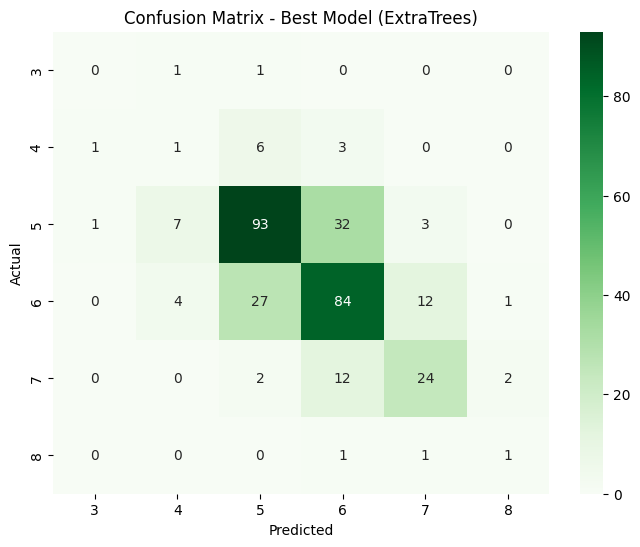


### Classification Report - ExtraTrees ###
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.08      0.09      0.08        11
           5       0.72      0.68      0.70       136
           6       0.64      0.66      0.65       128
           7       0.60      0.60      0.60        40
           8       0.25      0.33      0.29         3

    accuracy                           0.63       320
   macro avg       0.38      0.39      0.39       320
weighted avg       0.64      0.63      0.64       320



In [17]:
# 튜닝된 모델 중 가장 성능이 좋은 모델 찾기
best_tuned_name = None
best_tuned_score = 0
best_tuned_model = None

for name, model in tuned_estimators:
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Test Accuracy: {acc:.4f}")
    if acc > best_tuned_score:
        best_tuned_score = acc
        best_tuned_name = name
        best_tuned_model = model

print(f"\n최고 성능 모델: {best_tuned_name} (Accuracy: {best_tuned_score:.4f})")

# 최고 성능 모델의 Confusion Matrix 시각화
best_pred = best_tuned_model.predict(X_test_scaled)
labels = sorted(y_test.unique())

print(f"\n### Confusion Matrix - {best_tuned_name} ###")
cm_best = confusion_matrix(y_test, best_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, 
            annot=True, 
            fmt='d', 
            cmap='Greens',
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Best Model ({best_tuned_name})')
plt.show()

print(f"\n### Classification Report - {best_tuned_name} ###")
print(classification_report(y_test, best_pred))

## 6. 모델 평가 및 결론

### Confusion Matrix ###


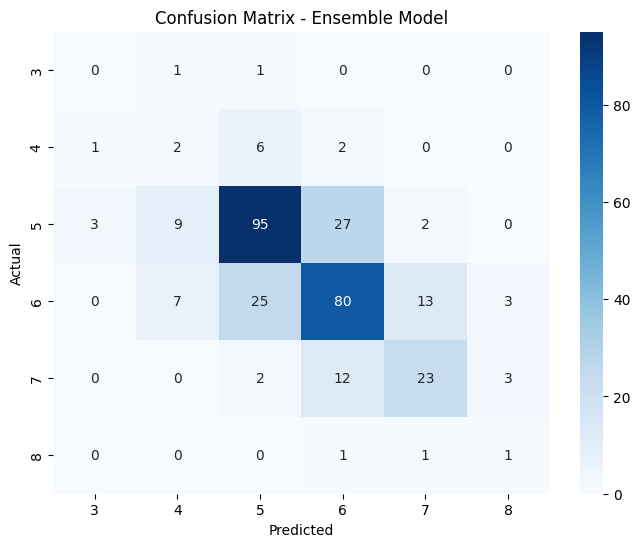

In [18]:
# 실제 클래스 라벨 추출 (3, 4, 5, 6, 7, 8)
labels = sorted(y_test.unique())

print("### Confusion Matrix ###")
cm = confusion_matrix(y_test, ensemble_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=labels,  # x축에 3~8 표시
            yticklabels=labels)  # y축에 3~8 표시
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Ensemble Model')
plt.show()

In [19]:
print(y_train.value_counts())
print(y_test.value_counts())

quality
5    545
6    510
7    159
4     42
8     15
3      8
Name: count, dtype: int64
quality
5    136
6    128
7     40
4     11
8      3
3      2
Name: count, dtype: int64
